In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [17]:
def flame_rhs(t, y, parm):
    return y**2 - y**3 


In [18]:
def system_rhs(t, y, parm):
    dy1dt = -y[0] + 2*y[1]
    dy2dt = -3*y[1]
    return np.array([dy1dt, dy2dt])

In [19]:
import numpy as np

def rksolver(func, t0, t1, y0, aeps=1e-6, reps=1e-4, parm=None, h_init=1e-3, h_min=1e-8):
    """
    Adaptive RK23 Solver for systems of first-order ODEs.
    
    Parameters:
    - func : function(t, y, parm) -> dy/dt
    - t0 : start time
    - t1 : end time
    - y0 : initial condition (scalar or array)
    - aeps : absolute error tolerance
    - reps : relative error tolerance
    - parm : extra parameters to pass to func
    - h_init : initial step size guess
    - h_min : minimum allowed step size
    
    Returns:
    - t_list : array of time points
    - y_list : array of solution points
    - h_list : array of step sizes
    - error_list : array of estimated local errors
    - tol_list : array of tolerance values at each step
    """
    t = t0
    y = np.array(y0, dtype=float)
    h = h_init

    t_list = [t]
    y_list = [y.copy()]
    h_list = []
    error_list = []
    tol_list = []

    # Correct error estimator coefficients for RK23: b_hat = b - d
    b_hat = np.array([1/6, -1/3, 1/6])

    while t < t1:
        if t + h > t1:
            h = t1 - t  # Adjust last step exactly to t1

        # Compute stages
        k1 = func(t, y, parm)
        k2 = func(t + h/2, y + (h/2) * k1, parm)
        k3 = func(t + h, y - h*k1 + 2*h*k2, parm)

        # Compute third-order solution
        y3 = y + h * (1/6 * k1 + 2/3 * k2 + 1/6 * k3)

        # Estimate local error
        sum_bf = b_hat[0]*k1 + b_hat[1]*k2 + b_hat[2]*k3
        if np.isscalar(sum_bf) or sum_bf.ndim == 0:
            E = np.abs(h * sum_bf)
            tol = reps * np.abs(y) + aeps
        else:
            E = np.linalg.norm(h * sum_bf, ord=2)
            tol = reps * np.linalg.norm(y, ord=2) + aeps

        # Store tracking info
        h_list.append(h)
        error_list.append(E)
        tol_list.append(tol)

        # Accept or reject step
        if E <= tol:
            t += h
            y = y3
            t_list.append(t)
            y_list.append(y.copy())

        # Update step size
        safety = 0.9
        if E == 0:
            h_new = h * 2
        else:
            h_new = h * safety * (tol / E)**(1/3)

        h = max(h_min, h_new)

    return np.array(t_list), np.array(y_list), np.array(h_list), np.array(error_list), np.array(tol_list)


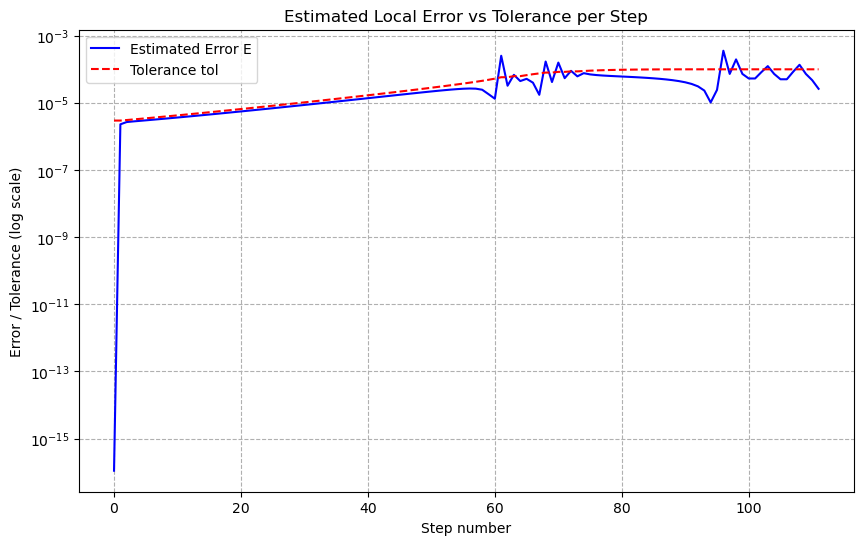

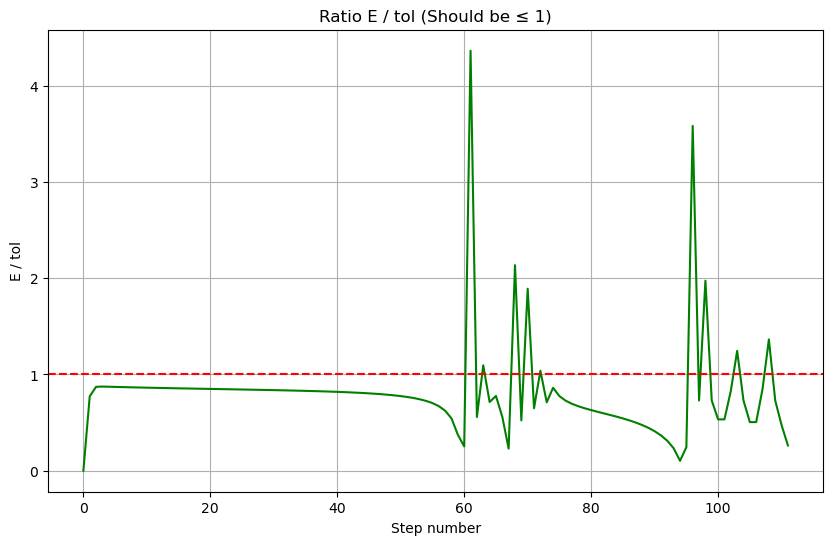

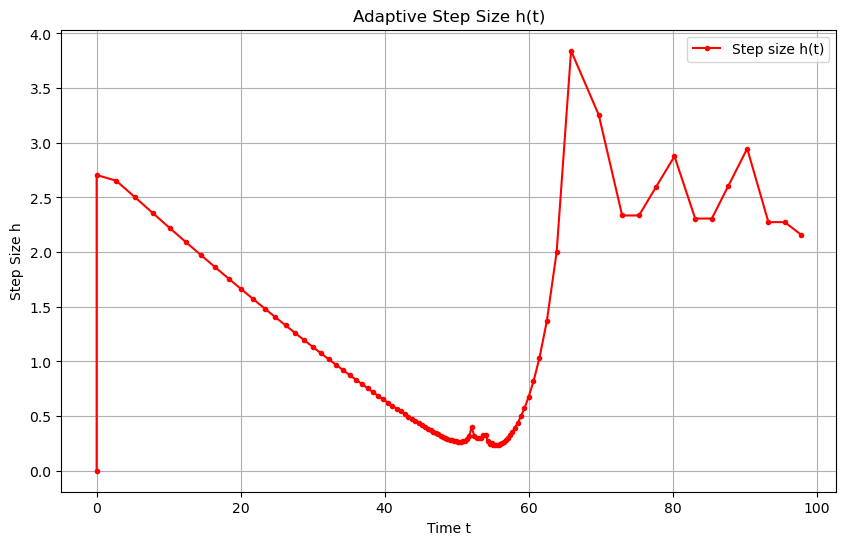

Total number of steps taken: 103


In [20]:
# Solve using your RK23 solver (if not done yet)
delta = 0.02
t0 = 0
t1 = 2 / delta
y0 = delta

t_list, y_list, h_list, error_list, tol_list = rksolver(flame_rhs, t0, t1, y0, aeps=1e-6, reps=1e-4, parm=None)

# Artificial x-axis: just step numbers
steps = np.arange(len(error_list))

# Plot estimated local error E(t)
plt.figure(figsize=(10,6))
plt.plot(steps, error_list, 'b-', label='Estimated Error E')
plt.plot(steps, tol_list, 'r--', label='Tolerance tol')
plt.yscale('log')
plt.xlabel('Step number')
plt.ylabel('Error / Tolerance (log scale)')
plt.title('Estimated Local Error vs Tolerance per Step')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

# Plot E(t)/tol(t) to check if <= 1
plt.figure(figsize=(10,6))
plt.plot(steps, np.array(error_list)/np.array(tol_list), 'g-')
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel('Step number')
plt.ylabel('E / tol')
plt.title('Ratio E / tol (Should be ≤ 1)')
plt.grid(True)
plt.show()


# Plot step sizes h(t)
h_list = np.diff(t_list)

plt.figure(figsize=(10,6))
plt.plot(t_list[:-1], h_list, 'r.-', label='Step size h(t)')
plt.xlabel('Time t')
plt.ylabel('Step Size h')
plt.title('Adaptive Step Size h(t)')
plt.grid(True)
plt.legend()
plt.show()

# Print number of steps
print(f"Total number of steps taken: {len(t_list)-1}")



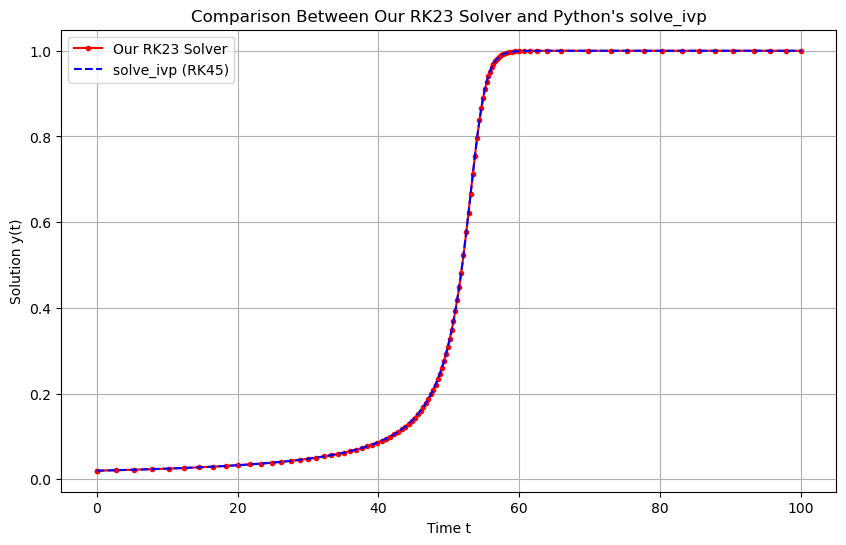

In [21]:
sol = solve_ivp(
    flame_rhs, 
    [t0, t1], 
    [y0], 
    args=(None,), 
    rtol=1e-4, 
    atol=1e-6, 
    dense_output=True
)

# Create a fine time grid for plotting
t_fine = np.linspace(t0, t1, 1000)
y_fine = sol.sol(t_fine)[0]

# Plotting
plt.figure(figsize=(10,6))

# Plot your RK23 solver
plt.plot(t_list, y_list, 'ro-', markersize=3, label='Our RK23 Solver')

# Plot solve_ivp result
plt.plot(t_fine, y_fine, 'b--', label='solve_ivp (RK45)')

plt.xlabel('Time t')
plt.ylabel('Solution y(t)')
plt.title('Comparison Between Our RK23 Solver and Python\'s solve_ivp')
plt.legend()
plt.grid(True)
plt.show()

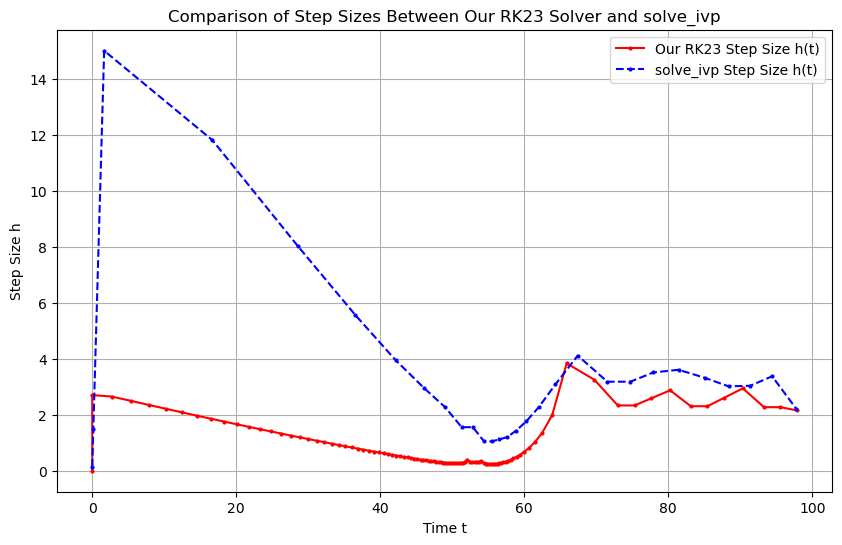

In [22]:
# After you solve with solve_ivp and your rksolver...

# Step sizes from solve_ivp
h_ivp = np.diff(sol.t)

# Step sizes from your solver (already have h_list)

# Plot step size comparison
plt.figure(figsize=(10,6))

plt.plot(t_list[:-1], h_list, 'r.-', markersize=4, label='Our RK23 Step Size h(t)')
plt.plot(sol.t[:-1], h_ivp, 'b.--', markersize=4, label='solve_ivp Step Size h(t)')

plt.xlabel('Time t')
plt.ylabel('Step Size h')
plt.title('Comparison of Step Sizes Between Our RK23 Solver and solve_ivp')
plt.legend()
plt.grid(True)
plt.show()
